# Pruning Deep Neural Nets

In this Notebook, we’re going to take MobileNet-224 and make it 16% smaller. In other words, we’re going to reduce it from 4 million parameters to approx 3.5 million — without losing a lot on accuracy.



# Can we do better ?

The question is: does MobileNet have any connections it doesn’t really need? Even though this model is already quite small, can we make it even smaller - without making it worse?

When we prune a neural network, the tradeoff is network size vs. accuracy. In general, the smaller the network, the faster it runs (and the less battery power it uses) but the worse its predictions are. MobileNet scores better than SqueezeNet, for example, but is also 3.4 times larger.

Ideally, we want to find the smallest possible neural net that can most accurately represent the thing we want it to learn. This is an open problem in machine learning, and until there is a good theory of how to do this, we’re going to have to start with a larger network and lobotomize it.

For this project we have used the pre-trained version of MobileNet. Evaluating this model on the ImageNet ILSVRC 2012 validation set gives the following scores:

Top-1 accuracy over 50000 images = 67.1%
Top-5 accuracy over 50000 images = 86.4%

This means it has guessed the correct answer 67.1% of the time, while 86.4% of the time the correct answer was among its five best guesses. We want the compressed model to get an accuracy that is comparable to these scores.


In [39]:
#Importing Libraries

In [ ]:
import os
import sys
import time
import random
import numpy as np

from collections import defaultdict
from tqdm import tqdm

import keras
from keras.applications import mobilenet
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Model, load_model
from keras import applications
from keras import optimizers
from keras import backend as K

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
keras.__version__, tf.__version__

('2.0.8', '1.3.0')

In [37]:
# The directories with the ImageNet data and labels. We're using the
# labels that come with Caffe.

In [4]:
ilsvrc_path = "../ILSVRC/Data/"
caffe_path = "../ILSVRC2012/caffe_ilsvrc12/"

image_height = 224
image_width = 224
batch_size = 64
num_classes = 1000

Supporting Code

In [5]:
from keras.preprocessing.image import Iterator

class ImageListIterator(Iterator):
    """Iterator yielding data from a list of image names.
    
    This is based on Keras's DirectoryIterator but instead of reading image
    filenames from a directory, it reads them from an array.

    # Arguments
        directory: Path to the directory to read images from.
        image_list: List of image filenames in `directory`.
        labels: Dictionary mapping the image filenames to class indices.
        num_class: Total number of classes.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
    """

    def __init__(self, directory, image_list, labels, num_class, 
                 image_data_generator, target_size=(256, 256), 
                 batch_size=32, shuffle=False, seed=None):

        self.directory = directory
        self.image_list = image_list
        self.samples = len(image_list)
        self.labels = labels
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_class))

        super(ImageListIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)

        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())
        batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            fname = self.image_list[j]
            img = image.load_img(os.path.join(self.directory, fname),
                                 target_size=self.target_size)
            x = image.img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i, self.labels[fname]] = 1  # one-hot encoded            

        return batch_x, batch_y

# How to Prune a Convolutional Neural Net

Instead of pruning away individual connections we’ll remove complete convolution filters. This keeps our connections dense and the GPU happy.

A convolution layer produces an image with a certain number of output channels. Each of these output channels contains the result of a single convolution filter. Such a filter takes the weighted sum over all the input channels and writes this sum to a single output channel.

We’re going to find the convolution filters that are the least important and remove their output channels from the layer.

There are different metrics we can use to estimate a filter’s relevance, but we’ll be using a very simple one - the L1-norm of the filter’s weights, which just means we take the absolute values of the filter’s weights and add them all up.

Removing filters from a layer means the number of output channels for that layer becomes smaller. Naturally, this has an effect on the next layer in the network too because that layer now receives fewer input channels.

As a result, we also have to remove the corresponding input channels from that layer. And when the convolution is followed by batch normalization, we also have to remove these channels from the batch norm parameters.

In [6]:
def divup(a, b):
    """Divides a by b and rounds up to the nearest integer."""
    return (a + b - 1) // b


def load_original():
    model = MobileNet(weights="imagenet")
    model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return model


def load_and_compile(model_path):
    model = load_model(model_path, custom_objects={
                      'relu6': mobilenet.relu6,
                      'DepthwiseConv2D': mobilenet.DepthwiseConv2D})
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return model


def count_weights(model):
    return int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))


def get_l1_norms(model, layer_ix):
    # Get the weights for the layer.
    layer = model.layers[layer_ix]
    W = layer.get_weights()[0]

    # Sum up all the weights for each filter.
    l1 = np.sum(np.abs(W), axis=(0,1,2))

    # Make list of (filter_ix, l1_norm), sorted by l1_norm (low to high).
    l1_norms = sorted(list(zip(range(len(l1)), l1)), key=lambda x: x[1])
    return l1_norms


def plot_l1_norms(model, layer_ix):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(list(map(lambda x: x[1], get_l1_norms(model, layer_ix))))
    plt.xlabel("Output channel", fontsize=18)
    plt.ylabel("L1 norm", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.title(model.layers[layer_ix].name, fontsize=18)
    

def print_savings(new_model):
    """How much have we compressed the model by pruning?"""
    total_params_after = count_weights(new_model)
    print("Before: %d parameters" % total_params_before)
    print("After: %d parameters" % total_params_after)
    print("Saved: %d parameters" % (total_params_before - total_params_after))
    print("Compressed to %.2f%% of original" % (100*total_params_after / total_params_before))

In [7]:
def create_new_val_sample(size=1000):
    steps = divup(size, batch_size)
    image_list = []
    for img_idx in random.sample(range(1, 50001), steps*batch_size):
        image_list.append("ILSVRC2012_val_000%05d.JPEG" % img_idx)
    return image_list


def eval_on_sample(model, val_sample):
    gen = ImageListIterator(val_data_dir, val_sample, val_labels, num_classes, 
                            val_datagen, target_size=(image_height, image_width), 
                            batch_size=batch_size)

    steps = len(val_sample) // batch_size
    return model.evaluate_generator(gen, steps=steps)


def eval_full(model):
    """Evaluate the model on the full validation set."""
    gen = ImageListIterator(val_data_dir, val_image_list, val_labels, num_classes, 
                            val_datagen, target_size=(image_height, image_width), 
                            batch_size=batch_size)

    return model.evaluate_generator(gen, steps=divup(50000, batch_size))


In [8]:
# NOTE: The following code is specific to MobileNet. It's not very pretty
# and uses a dirty trick to create a new model from the old one.
# For a more robust approach see https://github.com/BenWhetton/keras-surgeon

def delete_conv_filters(model, layer_ix, channel_indices):
    """Remove output channels from a (pointwise) convolution layer that is 
    followed by a depthwise convolution and a pointwise convolution.
    
    Also removes the corresponding channels from:
    - the BatchNorm layer that follows the conv layer
    - the depthwise conv layer
    - its BatchNorm layer
    - the pointwise conv layer after that
    
    This is necessary because a DepthwiseConv2D layer does not have a filters
    property; it outputs the same number of filters that are passed in.
    """
    
    # Remove the output channels
    layer = model.layers[layer_ix]
    channel_count = layer.get_config()["filters"] - len(channel_indices)
    weights = [np.delete(w, channel_indices, axis=-1) for w in layer.get_weights()]

    # Remove the output channels from the BatchNorm layer as well
    BN_layer = model.layers[layer_ix + 1]
    BN_weights = [np.delete(w, channel_indices, axis=-1) for w in BN_layer.get_weights()]

    # Remove the input channels from the following depthwise conv layer
    dw_layer = model.layers[layer_ix + 3]
    dw_weights = [np.delete(dw_layer.get_weights()[0], channel_indices, axis=2)]
    
    # And from the next layer's BatchNorm layer as well
    dw_BN_layer = model.layers[layer_ix + 4]
    dw_BN_weights = [np.delete(w, channel_indices, axis=-1) for w in dw_BN_layer.get_weights()]
    
    # Remove the input channels from the next conv layer (no bias).
    pw_layer = model.layers[layer_ix + 6]
    pw_weights = [np.delete(pw_layer.get_weights()[0], channel_indices, axis=2)]

    # Dirty trick: this changes the config for the current model, but that
    # does not seem to matter. This is what allows us to make a new model.
    layer.filters = channel_count
    
    return (weights, BN_weights, dw_weights, dw_BN_weights, pw_weights)


def load_new_conv_weights(model, new_model, layer_ix, w1, w2, w3, w4, w5):
    """Load the new weights into the changed layers (this is kinda slow)."""
    for ix in tqdm(range(len(model.layers))):
        layer = model.layers[ix]
        W = layer.get_weights()
        if ix == layer_ix:
            new_model.layers[ix].set_weights(w1)
        elif ix == layer_ix + 1:
            new_model.layers[ix].set_weights(w2)
        elif ix == layer_ix + 3:
            new_model.layers[ix].set_weights(w3)
        elif ix == layer_ix + 4:
            new_model.layers[ix].set_weights(w4)
        elif ix == layer_ix + 6:
            new_model.layers[ix].set_weights(w5)
        elif len(W) > 0:
            new_model.layers[ix].set_weights(W)


def prune_conv_layer(model, layer_ix, num_remove):
    l1_norms = get_l1_norms(model, layer_ix)
    num_original = len(l1_norms)
    print("Pruning %d of %d filters from layer %s" % (num_remove, num_original, model.layers[layer_ix].name))
    
    # Get a sorted list of the filter indices to remove.
    l1_norms_pruned = l1_norms[:num_remove]
    channels_to_prune = sorted(list(map(lambda x: x[0], l1_norms_pruned)))
    
    w1, w2, w3, w4, w5 = delete_conv_filters(model, layer_ix, channels_to_prune)
    
    new_model = model.__class__.from_config(model.get_config(), custom_objects={
                          'relu6': mobilenet.relu6,
                          'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

    # This is just so we can repeat the experiment more than once
    model.layers[layer_ix].filters = num_original
    
    load_new_conv_weights(model, new_model, layer_ix, w1, w2, w3, w4, w5)
    
    new_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    
    return new_model


def prune_last_layer(model, num_remove):
    layer_ix = 79
    l1_norms = get_l1_norms(model, layer_ix)
    num_original = len(l1_norms)
    print("Pruning %d of %d filters from layer %s" % (num_remove, num_original, model.layers[layer_ix].name))

    l1_norms_pruned = l1_norms[:num_remove]
    channel_indices = sorted(list(map(lambda x: x[0], l1_norms_pruned)))

    # Remove the output channels
    layer = model.layers[layer_ix]
    channel_count = layer.get_config()["filters"] - len(channel_indices)
    weights = [np.delete(w, channel_indices, axis=-1) for w in layer.get_weights()]

    # Remove the output channels from the BatchNorm layer as well
    BN_layer = model.layers[layer_ix + 1]
    BN_weights = [np.delete(w, channel_indices, axis=-1) for w in BN_layer.get_weights()]

    # Change the output shape of the reshape layer
    reshape_layer = model.layers[layer_ix + 4]
    reshape_layer.target_shape = (1, 1, channel_count)

    # Remove the input channels from the next conv layer (this layer also has 
    # bias, but we don't need to change those as bias is for output, not input).
    next_layer = model.layers[layer_ix + 6]
    next_weights = [np.delete(next_layer.get_weights()[0], channel_indices, axis=2),
                    next_layer.get_weights()[1]]

    # Dirty trick: this changes the config for the current model, but that
    # does not seem to matter. This is what allows us to make a new model.
    layer.filters = channel_count

    # Create a new model with the changed number of filters
    new_model = model.__class__.from_config(model.get_config(), custom_objects={
                          'relu6': mobilenet.relu6,
                          'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

    # This is just so we can repeat the experiment more than once.
    model.layers[layer_ix].filters = 1024

    for ix in tqdm(range(len(model.layers))):
        layer = model.layers[ix]
        W = layer.get_weights()
        if ix == layer_ix:
            new_model.layers[ix].set_weights(weights)
        elif ix == layer_ix + 1:
            new_model.layers[ix].set_weights(BN_weights)
        elif ix == layer_ix + 6:
            new_model.layers[ix].set_weights(next_weights)
        elif len(W) > 0:
            new_model.layers[ix].set_weights(W)

    new_model.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["categorical_accuracy", "top_k_categorical_accuracy"])
    return new_model

# Retraining

Because removing filters from a layer makes the accuracy of the network worse — after all we are throwing away things that the neural net has learned, even if they may not be very important — we need to retrain the network a little, so that it can learn to compensate for the parts we just cut out.

Retraining just means we call model.fit() again. A little trial-and-error led me to a learning rate of 0.00003 — quite small, but anything larger might make the training spin out of control. The reason the learning rate must be so small is that at this point the network is mostly trained already and we only want to make small changes to tweak the results.

The process then is:

remove filters (i.e. output channels) from a layer, in multiples of 4
retrain the network for a few epochs
evaluate on the validation set to see if the network has regained its previous accuracy
move to the next layer and repeat these steps

This process is quite labor-intensive, since we only compress one layer at a time and we need to retrain the network after every change. Figuring out how many filters to drop in each layer is not obvious either.

In [9]:
def create_train_sample(train_samples_per_folder):
    """Grabs train_samples_per_folder random image files from each class."""
    train_image_list = []
    for key in list(train_files.keys()):
        for i in range(train_samples_per_folder):
            img_idx = np.random.randint(0, len(train_files[key]))
            img_name = train_files[key][img_idx]
            full_name = os.path.join(key, img_name)
            train_image_list.append(full_name)

    random.shuffle(train_image_list)
    return train_image_list

def train_on_new_sample(model, val_sample, epochs, lr, train_samples_per_folder=5):
    """Train on a random sample of training images. This sample does not change 
    between epochs (but will be shuffled)."""
    train_sample = create_train_sample(train_samples_per_folder)
    
    num_train_samples = train_samples_per_folder*num_classes
    num_val_samples = len(val_sample)

    train_gen = ImageListIterator(train_data_dir, train_sample, train_labels, num_classes, 
                                  train_datagen, target_size=(image_height, image_width), 
                                  batch_size=batch_size, shuffle=True)

    val_gen = ImageListIterator(val_data_dir, val_sample, val_labels, num_classes, 
                                val_datagen, target_size=(image_height, image_width), 
                                batch_size=batch_size)

    model.optimizer.lr = lr

    model.fit_generator(
        train_gen,
        steps_per_epoch=divup(num_train_samples, batch_size),
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=divup(num_val_samples, batch_size))
    
def train_full(model, epochs, lr):
    """Retrains on the entire ImageNet training set and validates on the
    complete validation set."""
    train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

    # Note: could also do data augmentation here.
    # train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
    #                                          rotation_range=40,
    #                                          width_shift_range=0.2,
    #                                          height_shift_range=0.2,
    #                                          shear_range=0.2,
    #                                          zoom_range=0.2,
    #                                          horizontal_flip=True,
    #                                          fill_mode="nearest")
    
    train_gen = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode="categorical")
    
    val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

    val_gen = ImageListIterator(val_data_dir, val_image_list, val_labels, num_classes, 
                                val_datagen, target_size=(image_height, image_width), 
                                batch_size=batch_size)
    model.optimizer.lr = lr

    num_train_samples = 1281167
    num_val_samples = 50000

    model.fit_generator(
        train_gen,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=divup(num_val_samples, batch_size))

Load the Model

In [10]:
model = load_original()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [12]:
# This is used to compute by how much we've compressed the model.
total_params_before = count_weights(model)
total_params_before

4231976

In [13]:
label_names_file = caffe_path + "synset_words.txt"

label_names = np.loadtxt(label_names_file, str, delimiter="\t")



In [14]:
val_data_dir = ilsvrc_path + "CLS-LOC/val"
val_labels_file = caffe_path + "/val.txt"
val_labels = {}
with open(val_labels_file, "r") as f:
    for line in f.readlines():
        items = line.split(" ")
        val_labels[items[0]] = int(items[1])

val_data_dir = "/Users/neelambabel/Desktop/Research Study/ISLVRC2012"
val_labels_file = "/Users/neelambabel/Desktop/Research Study/ISLVRC2012/val.txt"
val_labels = {}
with open(val_labels_file, "r") as f:
    for line in f.readlines():
        items = line.split(" ")
        val_labels[items[0]] = int(items[1])

The list of images making up the complete validation set:


In [15]:
val_image_list = []
for img_idx in range(1, 50001):
    val_image_list.append("ILSVRC2012_val_000%05d.JPEG" % img_idx)


Load the training labels and filenames into dictionaries.

In [16]:
train_data_dir = ilsvrc_path + "CLS-LOC/train"
train_labels_file = caffe_path + "train.txt"

train_files = defaultdict(list)
train_labels = {}
with open(train_labels_file, "r") as f:
    for line in f.readlines():
        (path, class_idx) = line.split(" ")
        (class_name, filename) = path.split("/")
        train_labels[path] = int(class_idx)
        train_files[class_name].append(filename)

Create other objects we need:

In [17]:
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)


Making predictions

Just to make sure the neural net works OK, predict the outcome for an image from the validation set.

In [18]:
img_name = "ILSVRC2012_val_00000007.JPEG"

img_path = os.path.join(val_data_dir, img_name)
img = image.load_img(img_path, target_size=(image_height, image_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
probabilities = model.predict(x)[0]



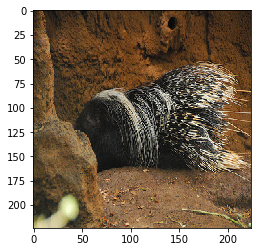

In [19]:
plt.imshow(img)

Look at the predicted probability distribution over the classes.

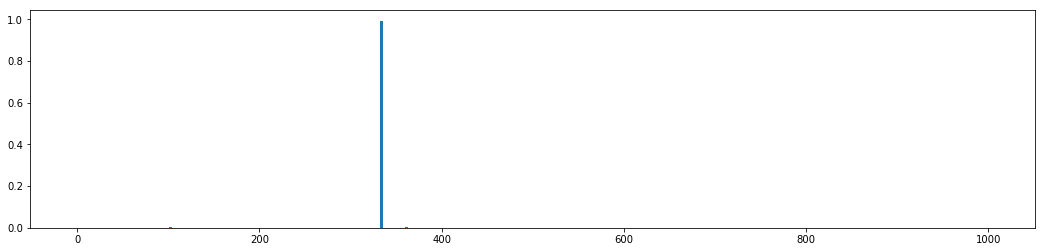

In [20]:
fig = plt.figure(figsize=(18,4))
plt.bar(range(0, 1000), probabilities, width=3)
plt.show()


Top 5 predictions:

In [21]:
top_ixs = probabilities.argsort()[::-1][:5]
top_ixs
for i in top_ixs:
    print("%.5f %s" % (probabilities[i], label_names[i]))

0.99328 n02346627 porcupine, hedgehog
0.00253 n02445715 skunk, polecat, wood pussy
0.00150 n01872401 echidna, spiny anteater, anteater
0.00042 n02397096 warthog
0.00041 n02396427 wild boar, boar, Sus scrofa


Just to make sure the neural net works OK, predict the outcome for an image from the validation set.

In [22]:


img_name = "ILSVRC2012_val_00000026.JPEG"
img_path = os.path.join(val_data_dir, img_name)
img = image.load_img(img_path, target_size=(image_height, image_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
probabilities = model.predict(x)[0]

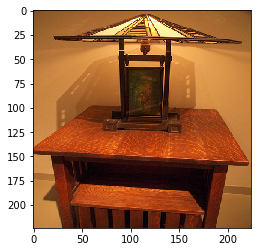

In [23]:
plt.imshow(img)

Look at the predicted probability distribution over the classes.

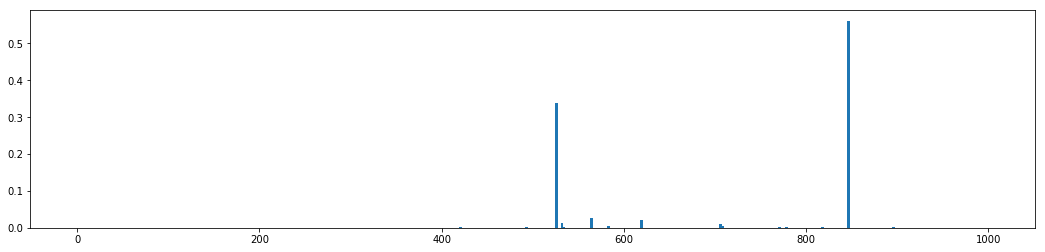

In [24]:
fig = plt.figure(figsize=(18,4))
plt.bar(range(0, 1000), probabilities, width=3)
plt.show()

Top 5 predictions:

In [25]:
top_ixs = probabilities.argsort()[::-1][:5]
top_ixs
for i in top_ixs:
    print("%.5f %s" % (probabilities[i], label_names[i]))

0.56172 n04380533 table lamp
0.33728 n03179701 desk
0.02756 n03388549 four-poster
0.02055 n03637318 lampshade, lamp shade
0.01367 n03201208 dining table, board


Ground truth:

In [26]:
print(val_labels[img_name], label_names[val_labels[img_name]])

846 n04380533 table lamp


What is the accuracy?

Check the model against a (random) sample from the ImageNet validation set.

# Using Samples

MobileNet is trained on the dataset for the ILSVRC competition, also known as ImageNet. This is a huge dataset, consisting of over 1.2 million training images.

Instead of using the full training set, we picked 10,000 training images in total. (Since I am running it on a CPU, every epoch takes about an hour to run)

For validation, we picked a random subset of 1,000 images from the full validation set. 

It turned out that just using these samples worked really well in practice.



In [27]:
val_sample = create_new_val_sample()

In [28]:
%time eval_on_sample(model, val_sample)

Found 1024 images belonging to 1000 classes.
CPU times: user 12min 14s, sys: 37.1 s, total: 12min 51s
Wall time: 3min 31s


[1.4638107419013977, 0.671875, 0.8642578125]

In [29]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_k_categorical_accuracy']

# L1 Norms

To determine which filters to remove, we sort them by L1-norm and remove the filters with the smallest L1-norms. You can read more about this approach in the paper Pruning Filters For Efficient Convnets by Li et al.
Plot the L1-norms for all layers. This should give some idea of how many filters we can remove per layer.

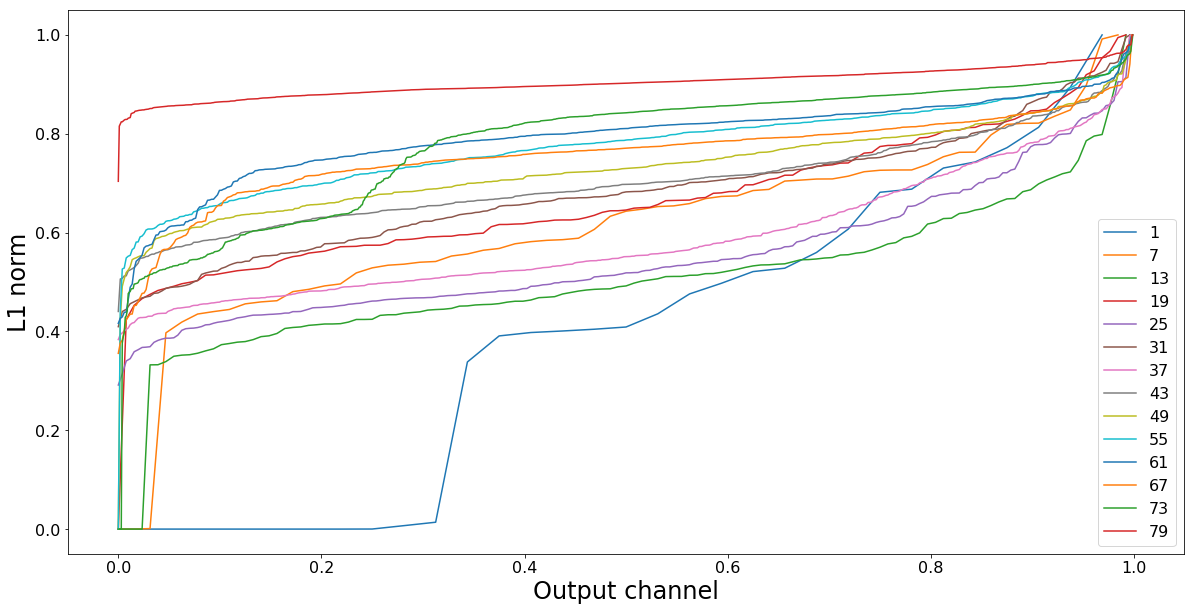

In [30]:
# Indices of the layers with convolutions (excluding depthwise)
layer_ixs = [1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73, 79]

fig = plt.figure(figsize=(20, 10))

for layer_ix in layer_ixs:
    l1_norms = get_l1_norms(model, layer_ix)
    max_value = l1_norms[-1][1]
    xs = np.arange(0, 1, 1. / len(l1_norms))
    ys = list(map(lambda x: x[1] / max_value, l1_norms))
    plt.plot(xs, ys)
    
plt.legend(layer_ixs, fontsize=16)
plt.xlabel("Output channel", fontsize=24)
plt.ylabel("L1 norm", fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)


Vertical axis is L1-norm divided by maximum L1-norm for that layer. Horizontal axis is (sorted) filter index divided by total number of filters for that layer. (This is like Fig 2(a) in the Li paper, but sorted from low to high.)

# Selecting which layer to be pruned

We can only remove filters (output channels) from the first convolution layer and the pointwise convolution layers.
Depthwise convolution layers cannot be compressed by removing output channels, since they need to have as many output channels as input channels. Besides, depthwise convolution layers don't really have that many parameters and are quite fast. And when we prune the other layers, we also prune the corresponding channels from the depthwise layers that follow.
It also makes no sense to remove output channels from the classification layer (conv_preds), since we need it to output predictions for all 1000 categories.
We start with the last layer in the network, since that is the biggest layer and we can make most gains here. (Because I want to be able to use this neural net with Metal, we must always remove filters in multiples of 4.)

conv_pw_13

This is the last convolution layer before the classification layer (which also happens to be convolutional in Keras's implementation of MobileNet).


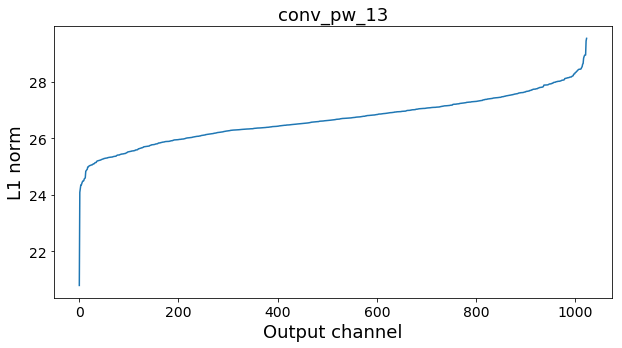

In [31]:
plot_l1_norms(model, 79)


# Pruning the last pointwise conv layer first

In the Keras version of MobileNet the classification layer also happens to be a convolution layer, but we cannot remove any output channels from it. Since this network is trained on ImageNet, which has 1000 categories, the classification layer should also have 1000 output channels. If we were to remove any of these output channels, the model can no longer make predictions for those categories.

The layer conv_pw_13 has 1024 output channels. We decided to remove 256 of those based on L-1 Norm Graph values. Since conv_pw_13 has 1,048,576 parameters and is the largest layer in the network, so we can make big gains here.

In [32]:
new_model = prune_last_layer(model, num_remove=320)

Pruning 320 of 1024 filters from layer conv_pw_13


100%|██████████| 88/88 [00:07<00:00, 12.18it/s]


In [33]:
print_savings(new_model)


Before: 4231976 parameters
After: 3583656 parameters
Saved: 648320 parameters
Compressed to 84.68% of original


Every time we prune a layer, it's important we re-train the model to get the accuracy back up to previous standards.

In [34]:
%time eval_on_sample(new_model, val_sample)

Found 1024 images belonging to 1000 classes.
CPU times: user 12min 7s, sys: 40.1 s, total: 12min 47s
Wall time: 3min 44s


[1.9325472414493561, 0.5693359375, 0.7783203125]

We've removed 16% of this layer's filters and the accuracy dropped by 11 points. We'll now retrain to try and recover from this.

In [38]:
train_on_new_sample(new_model, val_sample, epochs=1, lr=0.00003, train_samples_per_folder=10)

Found 10000 images belonging to 1000 classes.
Found 1024 images belonging to 1000 classes.
Epoch 1/1
157/157 [==============================] - 6501s - loss: 1.6047 - categorical_accuracy: 0.6157 - top_k_categorical_accuracy: 0.8429 - val_loss: 1.5070 - val_categorical_accuracy: 0.6494 - val_top_k_categorical_accuracy: 0.8438


# Conclusion

On the original model the validation set accuracy is:

Top-1 accuracy over 50000 images = 67.1%
Top-5 accuracy over 50000 images = 86.4%

The final pruned model has accuracy:
Before: 4231976 parameters
After: 3583656 parameters
Saved: 648320 parameters
Compressed to 84.68% of original

Top-1 accuracy over 50000 images = 56.9
Top-5 accuracy over 50000 images = 77.8

After re-training the model for 1 epoch the accuracy becomes:

Top-1 accuracy over 50000 images = 64.9
Top-5 accuracy over 50000 images = 84.3

Note that this isn't necessarily the best we can do. This approach of compressing the network layer-by-layer is very much trial & error. We can keep pruning the convolutional layers in the same fashion and re-train the model each time and finally evaluate the performance.

# Reference

The text in the document by < Matthijs Hollemans > is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
The code in the document by <Matthijs Hollemans> is licensed under the MIT License https://opensource.org/licenses/MIT